In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","10g") \
    .getOrCreate()

spark

In [4]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [5]:
# Loading the clean data
df = spark.read.parquet("final_df/final_df.parquet")

In [6]:
df_org = df

In [7]:
dfp = df_org.toPandas()
dfp

event_type product_id    brand    price    user_id     category  \
0             cart    1004835  samsung   230.89  532230882  electronics   
1         purchase    1801690  samsung   368.04  555467805  electronics   
2         purchase    1003306    apple   587.56  547952735  electronics   
3         purchase    1004870  samsung   286.86  555148121  electronics   
4         purchase   26402505   others   950.73  555463488         None   
...            ...        ...      ...      ...        ...          ...   
1245280   purchase   10400392   others    25.71  566267483         kids   
1245281   purchase    1004566   huawei   164.84  541238676  electronics   
1245282       cart    1005115    apple   949.47  566272904  electronics   
1245283   purchase    1304409    apple  1402.87  562780507    computers   
1245284   purchase    1004767  samsung   242.63  551781196  electronics   

        secondary_category   weekday hour_bucket  is_purchased  
0               smartphone   Tuesday       Night             0  
1                    video   Tuesday       Night             1  
2               smartphone   Tuesday       Night             1  
3               smartphone   Tuesday       Night             1  
4                     None   Tuesday       Night             1  
...                    ...       ...         ...           ...  
1245280               toys  Thursday       Night             1  
1245281         smartphone  Thursday       Night             1  
1245282         smartphone  Thursday       Night             0  
1245283           notebook  Thursday       Night             1  
1245284         smartphone  Thursday       Night             1  

[1245285 rows x 10 columns]

In [8]:
from pyspark.sql.functions import *
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

event_type  product_id  brand  price  user_id  category  \
0           0           0      0      0        0    226805   

   secondary_category  weekday  hour_bucket  is_purchased  
0              226805        0            0             0

In [9]:
df = df.fillna('others')

In [10]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

event_type  product_id  brand  price  user_id  category  \
0           0           0      0      0        0         0   

   secondary_category  weekday  hour_bucket  is_purchased  
0                   0        0            0             0

<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [11]:
# Additional steps for Logistic regression - Feature selection, Correlation, etc.

In [12]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

In [13]:
dfp.product_id.nunique()

44157

In [14]:
#drop product_id since it can't be encoded due high number of categories
df = df.drop('product_id')

In [15]:
#drop user_id since it is an identifier and it is unnecessary
df = df.drop("user_id")

In [16]:
#drop event_type since it was used to generate target variable is_purchased
df = df.drop('event_type')

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

In [18]:
stringCols = ['brand','category','secondary_category','weekday','hour_bucket']
for c in stringCols:
    outCol = c + '_ix'
    si = StringIndexer(inputCol=c, outputCol=outCol)
    df = si.fit(df).transform(df)

In [19]:
df.printSchema()

root
 |-- brand: string (nullable = false)
 |-- price: string (nullable = false)
 |-- category: string (nullable = false)
 |-- secondary_category: string (nullable = false)
 |-- weekday: string (nullable = false)
 |-- hour_bucket: string (nullable = false)
 |-- is_purchased: integer (nullable = true)
 |-- brand_ix: double (nullable = false)
 |-- category_ix: double (nullable = false)
 |-- secondary_category_ix: double (nullable = false)
 |-- weekday_ix: double (nullable = false)
 |-- hour_bucket_ix: double (nullable = false)



In [20]:
df.show(3)

+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+
|  brand| price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+
|samsung|230.89|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|
|samsung|368.04|electronics|             video|Tuesday|      Night|           1|     1.0|        0.0|                  4.0|       1.0|           1.0|
|  apple|587.56|electronics|        smartphone|Tuesday|      Night|           1|     2.0|        0.0|                  0.0|       1.0|           1.0|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------

In [21]:
categoricalCols = [c+'_ix' for c in stringCols]
ohe = OneHotEncoderEstimator(inputCols=categoricalCols, outputCols=[c+'_Enc' for c in categoricalCols])
enc_model = ohe.fit(df)
df = enc_model.transform(df)

In [22]:
df.printSchema()

root
 |-- brand: string (nullable = false)
 |-- price: string (nullable = false)
 |-- category: string (nullable = false)
 |-- secondary_category: string (nullable = false)
 |-- weekday: string (nullable = false)
 |-- hour_bucket: string (nullable = false)
 |-- is_purchased: integer (nullable = true)
 |-- brand_ix: double (nullable = false)
 |-- category_ix: double (nullable = false)
 |-- secondary_category_ix: double (nullable = false)
 |-- weekday_ix: double (nullable = false)
 |-- hour_bucket_ix: double (nullable = false)
 |-- brand_ix_Enc: vector (nullable = true)
 |-- secondary_category_ix_Enc: vector (nullable = true)
 |-- category_ix_Enc: vector (nullable = true)
 |-- hour_bucket_ix_Enc: vector (nullable = true)
 |-- weekday_ix_Enc: vector (nullable = true)



In [23]:
df.show(3)

+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|  brand| price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|samsung|230.89|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],[1.0])| (6,[1],[1.0])|
|samsung|368.04|electronics|        

In [24]:
from pyspark.sql.types import IntegerType
df = df.withColumn("price", df["price"].cast(IntegerType()))

In [25]:
df.show(3)

+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|  brand|price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|
+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|samsung|  230|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],[1.0])| (6,[1],[1.0])|
|samsung|  368|electronics|             

In [26]:
trainCols = [c+'_Enc' for c in categoricalCols] + ['price']
assembler = VectorAssembler(inputCols=trainCols, outputCol='features_')
df = assembler.transform(df)
df.show(3)

+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+--------------------+
|  brand|price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|           features_|
+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+--------------------+
|samsung|  230|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],

In [27]:
df = df.drop(*stringCols)
df = df.drop(*[c+'_ix' for c in stringCols])
df = df.drop(*[c+'_Enc' for c in categoricalCols])
df = df.drop('price')

In [28]:
df.printSchema()

root
 |-- is_purchased: integer (nullable = true)
 |-- features_: vector (nullable = true)



In [29]:
df.show(3)

+------------+--------------------+
|is_purchased|           features_|
+------------+--------------------+
|           0|(98,[1,20,33,90,9...|
|           1|(98,[1,20,37,90,9...|
|           1|(98,[2,20,33,90,9...|
+------------+--------------------+
only showing top 3 rows



In [30]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features_', outputCol='features')
scaler_m = scaler.fit(df)
df = scaler_m.transform(df)
df.show(3)

# from pyspark.ml.feature import MinMaxScaler
# scaler = MinMaxScaler(min=0, max=1, inputCol='features_', outputCol='features')
# scaler_model = scaler.fit(df)
# df = scaler_model.transform(df)
# df.show(3)

+------------+--------------------+--------------------+
|is_purchased|           features_|            features|
+------------+--------------------+--------------------+
|           0|(98,[1,20,33,90,9...|(98,[1,20,33,90,9...|
|           1|(98,[1,20,37,90,9...|(98,[1,20,37,90,9...|
|           1|(98,[2,20,33,90,9...|(98,[2,20,33,90,9...|
+------------+--------------------+--------------------+
only showing top 3 rows



In [31]:
df = df.drop('features_')

In [32]:
dfp.is_purchased.value_counts()   #approximately same no of purchases as no of additions to cart

# appx 50% conversion rate from cart to purchase

# no need for stratified sampling for train test split as dataset is fairly balanced

1    658740
0    586545
Name: is_purchased, dtype: int64

#### Train-test split

In [33]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = df.randomSplit([0.8,0.2], seed=2022)

In [34]:
train.show(2)

+------------+--------------------+
|is_purchased|            features|
+------------+--------------------+
|           0|(98,[0,20,33,89,9...|
|           0|(98,[0,20,33,89,9...|
+------------+--------------------+
only showing top 2 rows



In [35]:
test.show(2)

+------------+--------------------+
|is_purchased|            features|
+------------+--------------------+
|           0|(98,[0,20,33,89,9...|
|           0|(98,[0,20,33,89,9...|
+------------+--------------------+
only showing top 2 rows



In [36]:
# Number of rows in train and test data
print(train.count())
print(test.count())

996456
248829


#### Model Fitting

In [37]:
# Building and Fitting the model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='is_purchased')
model = lr.fit(train)
result_tr = model.evaluate(train)

result = model.evaluate(test)

In [38]:
# Evaluating the model

print("Accuracy on Test and Train Set")
print(result.accuracy,result_tr.accuracy,"\n")

print("AUC on Test and Train Set")
print(result.areaUnderROC,result_tr.areaUnderROC,"\n")

print("Precision on Test and Train Set")
print(result.precisionByLabel,result_tr.precisionByLabel,"\n")

print("Recall on Test and Train Set")
print(result.recallByLabel,result_tr.recallByLabel,"\n")

Accuracy on Test and Train Set
0.5852894959992605 0.585784018561783 

AUC on Test and Train Set
0.6215760791492425 0.6225228060716599 

Precision on Test and Train Set
[0.5457607063213944, 0.6492769790986971] [0.5459502519915461, 0.6500330399941262] 

Recall on Test and Train Set
[0.7158243013925248, 0.4689343265430222] [0.7156002011609373, 0.47022648810652906] 



In [39]:
predictions = result.predictions
pred = predictions.select(['is_purchased','features','rawPrediction','probability','prediction'])
pred.show()

+------------+--------------------+--------------------+--------------------+----------+
|is_purchased|            features|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------------+--------------------+----------+
|           0|(98,[0,20,33,89,9...|[-0.7219739316908...|[0.32695845790637...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7230202126834...|[0.32672825854126...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7245896341722...|[0.32638311598934...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7249819895445...|[0.32629685972143...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7256359151648...|[0.32615312540259...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7261590556611...|[0.32603816147369...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7262898407852...|[0.32600942376030...|       1.0|
|           0|(98,[0,20,33,89,9...|[-0.7266821961574...|[0.32592321846782...|       1.0|
|           0|(98,[0,

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

pred_ = pred.select('is_purchased','prediction').toPandas()

# target_names = ['0','1']

print("Confusion Matrix: ")
print(confusion_matrix(pred_.is_purchased, pred_.prediction,),"\n\n")
      
print(classification_report(pred_.is_purchased, pred_.prediction,)) #target_names=target_names))

Confusion Matrix: 
[[83944 33325]
 [69867 61693]] 


              precision    recall  f1-score   support

           0       0.55      0.72      0.62    117269
           1       0.65      0.47      0.54    131560

    accuracy                           0.59    248829
   macro avg       0.60      0.59      0.58    248829
weighted avg       0.60      0.59      0.58    248829



#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

#### Updated model, if any
Repeat the steps 

In [41]:
import pandas as pd

In [42]:
dfp

event_type product_id    brand    price    user_id     category  \
0             cart    1004835  samsung   230.89  532230882  electronics   
1         purchase    1801690  samsung   368.04  555467805  electronics   
2         purchase    1003306    apple   587.56  547952735  electronics   
3         purchase    1004870  samsung   286.86  555148121  electronics   
4         purchase   26402505   others   950.73  555463488         None   
...            ...        ...      ...      ...        ...          ...   
1245280   purchase   10400392   others    25.71  566267483         kids   
1245281   purchase    1004566   huawei   164.84  541238676  electronics   
1245282       cart    1005115    apple   949.47  566272904  electronics   
1245283   purchase    1304409    apple  1402.87  562780507    computers   
1245284   purchase    1004767  samsung   242.63  551781196  electronics   

        secondary_category   weekday hour_bucket  is_purchased  
0               smartphone   Tuesday       Night             0  
1                    video   Tuesday       Night             1  
2               smartphone   Tuesday       Night             1  
3               smartphone   Tuesday       Night             1  
4                     None   Tuesday       Night             1  
...                    ...       ...         ...           ...  
1245280               toys  Thursday       Night             1  
1245281         smartphone  Thursday       Night             1  
1245282         smartphone  Thursday       Night             0  
1245283           notebook  Thursday       Night             1  
1245284         smartphone  Thursday       Night             1  

[1245285 rows x 10 columns]

In [43]:
dfp.drop(['event_type','product_id','user_id'],axis=1,inplace=True)
dfp

brand    price     category secondary_category   weekday  \
0        samsung   230.89  electronics         smartphone   Tuesday   
1        samsung   368.04  electronics              video   Tuesday   
2          apple   587.56  electronics         smartphone   Tuesday   
3        samsung   286.86  electronics         smartphone   Tuesday   
4         others   950.73         None               None   Tuesday   
...          ...      ...          ...                ...       ...   
1245280   others    25.71         kids               toys  Thursday   
1245281   huawei   164.84  electronics         smartphone  Thursday   
1245282    apple   949.47  electronics         smartphone  Thursday   
1245283    apple  1402.87    computers           notebook  Thursday   
1245284  samsung   242.63  electronics         smartphone  Thursday   

        hour_bucket  is_purchased  
0             Night             0  
1             Night             1  
2             Night             1  
3             Night             1  
4             Night             1  
...             ...           ...  
1245280       Night             1  
1245281       Night             1  
1245282       Night             0  
1245283       Night             1  
1245284       Night             1  

[1245285 rows x 7 columns]

In [44]:
dfp.isna().sum()

brand                      0
price                      0
category              226805
secondary_category    226805
weekday                    0
hour_bucket                0
is_purchased               0
dtype: int64

In [45]:
dfp.fillna('others',inplace=True)

In [46]:
dfp.isna().sum()

brand                 0
price                 0
category              0
secondary_category    0
weekday               0
hour_bucket           0
is_purchased          0
dtype: int64

In [47]:
dfp

brand    price     category secondary_category   weekday  \
0        samsung   230.89  electronics         smartphone   Tuesday   
1        samsung   368.04  electronics              video   Tuesday   
2          apple   587.56  electronics         smartphone   Tuesday   
3        samsung   286.86  electronics         smartphone   Tuesday   
4         others   950.73       others             others   Tuesday   
...          ...      ...          ...                ...       ...   
1245280   others    25.71         kids               toys  Thursday   
1245281   huawei   164.84  electronics         smartphone  Thursday   
1245282    apple   949.47  electronics         smartphone  Thursday   
1245283    apple  1402.87    computers           notebook  Thursday   
1245284  samsung   242.63  electronics         smartphone  Thursday   

        hour_bucket  is_purchased  
0             Night             0  
1             Night             1  
2             Night             1  
3             Night             1  
4             Night             1  
...             ...           ...  
1245280       Night             1  
1245281       Night             1  
1245282       Night             0  
1245283       Night             1  
1245284       Night             1  

[1245285 rows x 7 columns]

In [48]:
dfp_ = pd.get_dummies(data=dfp, columns=['brand', 'category', 'secondary_category', 'weekday','hour_bucket'],drop_first=True)
dfp_

price  is_purchased  brand_apple  brand_artel  brand_bosch  \
0         230.89             0            0            0            0   
1         368.04             1            0            0            0   
2         587.56             1            1            0            0   
3         286.86             1            0            0            0   
4         950.73             1            0            0            0   
...          ...           ...          ...          ...          ...   
1245280    25.71             1            0            0            0   
1245281   164.84             1            0            0            0   
1245282   949.47             0            1            0            0   
1245283  1402.87             1            1            0            0   
1245284   242.63             1            0            0            0   

         brand_casio  brand_cordiant  brand_dauscher  brand_hp  brand_huawei  \
0                  0               0               0         0             0   
1                  0               0               0         0             0   
2                  0               0               0         0             0   
3                  0               0               0         0             0   
4                  0               0               0         0             0   
...              ...             ...             ...       ...           ...   
1245280            0               0               0         0             0   
1245281            0               0               0         0             1   
1245282            0               0               0         0             0   
1245283            0               0               0         0             0   
1245284            0               0               0         0             0   

         ...  secondary_category_video  secondary_category_wallet  \
0        ...                         0                          0   
1        ...                         1                          0   
2        ...                         0                          0   
3        ...                         0                          0   
4        ...                         0                          0   
...      ...                       ...                        ...   
1245280  ...                         0                          0   
1245281  ...                         0                          0   
1245282  ...                         0                          0   
1245283  ...                         0                          0   
1245284  ...                         0                          0   

         weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0                     0                 0               0                 0   
1                     0                 0               0                 0   
2                     0                 0               0                 0   
3                     0                 0               0                 0   
4                     0                 0               0                 0   
...                 ...               ...             ...               ...   
1245280               0                 0               0                 1   
1245281               0                 0               0                 1   
1245282               0                 0               0                 1   
1245283               0                 0               0                 1   
1245284               0                 0               0                 1   

         weekday_Tuesday  weekday_Wednesday  hour_bucket_Morning  \
0                      1                  0                    0   
1                      1                  0                    0   
2                      1                  0                    0   
3                      1                  0                    0   
4                      1                  0            

In [49]:
dfp[['brand','category','secondary_category','weekday','hour_bucket']] = dfp[['brand', 'category', 'secondary_category', 
                                                                            'weekday','hour_bucket']].astype('category')

In [50]:
dfp.dtypes

brand                 category
price                   object
category              category
secondary_category    category
weekday               category
hour_bucket           category
is_purchased             int32
dtype: object

In [51]:
dfp['price'] = dfp['price'].astype(float)

In [52]:
cats = ['brand','category','secondary_category','weekday','hour_bucket']
for x in cats:
    dfp[x]=dfp[x].cat.codes

In [53]:
dfp

brand    price  category  secondary_category  weekday  hour_bucket  \
0           18   230.89         7                  40        5            2   
1           18   368.04         7                  55        5            2   
2            1   587.56         7                  40        5            2   
3           18   286.86         7                  40        5            2   
4           14   950.73        11                  29        5            2   
...        ...      ...       ...                 ...      ...          ...   
1245280     14    25.71         9                  48        4            2   
1245281      8   164.84         7                  40        4            2   
1245282      1   949.47         7                  40        4            2   
1245283      1  1402.87         4                  28        4            2   
1245284     18   242.63         7                  40        4            2   

         is_purchased  
0                   0  
1                   1  
2                   1  
3                   1  
4                   1  
...               ...  
1245280             1  
1245281             1  
1245282             0  
1245283             1  
1245284             1  

[1245285 rows x 7 columns]

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = dfp.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dfp.values, i) for i in range(len(dfp.columns))]
  
print(vif_data)

              feature       VIF
0               brand  5.264550
1               price  2.799145
2            category  7.185774
3  secondary_category  9.173107
4             weekday  3.079952
5         hour_bucket  5.276059
6        is_purchased  2.060363


In [55]:
# we should ideally drop VIF >> 5 so we drop category and secondar_category

In [56]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(dfp.drop('is_purchased',axis=1))
log = sm.GLM(dfp['is_purchased'].astype(float),X_train_sm.astype(float),family = sm.families.Binomial())
res = log.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           is_purchased   No. Observations:              1245285
Model:                            GLM   Df Residuals:                  1245278
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5110e+05
Date:                Wed, 18 May 2022   Deviance:                   1.7022e+06
Time:                        13:23:29   Pearson chi2:                 1.25e+06
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01589
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2506      0.009     26.434      0.000       0.232       0.269
brand                 -0.0064      0.000    -19.555      0.000      -0.007      -0.006
price                 -0.0002   6.66e-06    -32.770      0.000      -0.000      -0.000
category               0.0670      0.001     91.695      0.000       0.066       0.068
secondary_category    -0.0134      0.000    -81.492      0.000      -0.014      -0.013
weekday                0.0270      0.001     30.110      0.000       0.025       0.029
hour_bucket           -0.0681      0.003    -22.341      0.000      -0.074      -0.062
======================================================================================
"""

- all variables are satistically significant

Feature: 0, Score: -0.00641
Feature: 1, Score: -0.00022
Feature: 2, Score: 0.06714
Feature: 3, Score: -0.01342
Feature: 4, Score: 0.02672
Feature: 5, Score: -0.06838


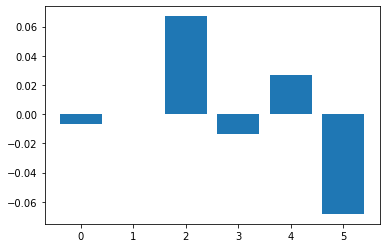

In [60]:
# logistic regression for feature importance
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
# define the model
modellr = LogisticRegression()
# fit the model
modellr.fit(dfp.drop('is_purchased',axis=1), dfp['is_purchased'])
# get importance
importance = modellr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [72]:
dfp.drop('is_purchased',axis=1).columns

Index(['brand', 'price', 'category', 'secondary_category', 'weekday',
       'hour_bucket'],
      dtype='object')

## category and hour affects the target_variable "is_purchased" most while ctageory has positive impact, hour has a negative impact

In [61]:
df_org.show()

+----------+----------+-------+------+---------+------------+------------------+-------+-----------+------------+
|event_type|product_id|  brand| price|  user_id|    category|secondary_category|weekday|hour_bucket|is_purchased|
+----------+----------+-------+------+---------+------------+------------------+-------+-----------+------------+
|      cart|   1004835|samsung|230.89|532230882| electronics|        smartphone|Tuesday|      Night|           0|
|  purchase|   1801690|samsung|368.04|555467805| electronics|             video|Tuesday|      Night|           1|
|  purchase|   1003306|  apple|587.56|547952735| electronics|        smartphone|Tuesday|      Night|           1|
|  purchase|   1004870|samsung|286.86|555148121| electronics|        smartphone|Tuesday|      Night|           1|
|  purchase|  26402505| others|950.73|555463488|        null|              null|Tuesday|      Night|           1|
|      cart|   1004210|samsung| 95.21|516204128| electronics|        smartphone|Tuesday|

In [62]:
df = df_org
df.show()

+----------+----------+-------+------+---------+------------+------------------+-------+-----------+------------+
|event_type|product_id|  brand| price|  user_id|    category|secondary_category|weekday|hour_bucket|is_purchased|
+----------+----------+-------+------+---------+------------+------------------+-------+-----------+------------+
|      cart|   1004835|samsung|230.89|532230882| electronics|        smartphone|Tuesday|      Night|           0|
|  purchase|   1801690|samsung|368.04|555467805| electronics|             video|Tuesday|      Night|           1|
|  purchase|   1003306|  apple|587.56|547952735| electronics|        smartphone|Tuesday|      Night|           1|
|  purchase|   1004870|samsung|286.86|555148121| electronics|        smartphone|Tuesday|      Night|           1|
|  purchase|  26402505| others|950.73|555463488|        null|              null|Tuesday|      Night|           1|
|      cart|   1004210|samsung| 95.21|516204128| electronics|        smartphone|Tuesday|

In [63]:
#drop redundant columns
df = df.drop('event_type')
df = df.drop('product_id')
df = df.drop('user_id')

In [64]:
#drop columns with VIF>>5 and retry modelling
df = df.drop('category')
df = df.drop('secondary_category')

In [65]:
df.show()

+-------+------+-------+-----------+------------+
|  brand| price|weekday|hour_bucket|is_purchased|
+-------+------+-------+-----------+------------+
|samsung|230.89|Tuesday|      Night|           0|
|samsung|368.04|Tuesday|      Night|           1|
|  apple|587.56|Tuesday|      Night|           1|
|samsung|286.86|Tuesday|      Night|           1|
| others|950.73|Tuesday|      Night|           1|
|samsung| 95.21|Tuesday|      Night|           0|
| others|236.30|Tuesday|      Night|           1|
| others| 15.42|Tuesday|      Night|           1|
| others| 13.51|Tuesday|      Night|           1|
|samsung|254.76|Tuesday|      Night|           0|
|samsung|128.45|Tuesday|    Evening|           1|
| others|239.21|Tuesday|    Evening|           1|
|samsung|254.76|Tuesday|    Evening|           0|
|samsung|253.31|Tuesday|    Evening|           0|
|samsung|787.11|Tuesday|    Morning|           0|
| huawei|100.72|Tuesday|    Morning|           1|
|     lg|334.32|Tuesday|    Morning|           1|


In [66]:
stringCols = ['brand','weekday','hour_bucket']
for c in stringCols:
    outCol = c + '_ix'
    si = StringIndexer(inputCol=c, outputCol=outCol)
    df = si.fit(df).transform(df)

categoricalCols = [c+'_ix' for c in stringCols]
ohe = OneHotEncoderEstimator(inputCols=categoricalCols, outputCols=[c+'_Enc' for c in categoricalCols])
enc_model = ohe.fit(df)
df = enc_model.transform(df)

df = df.withColumn("price", df["price"].cast(IntegerType()))

trainCols = [c+'_Enc' for c in categoricalCols] + ['price']
assembler = VectorAssembler(inputCols=trainCols, outputCol='features_')
df = assembler.transform(df)

df = df.drop(*stringCols)
df = df.drop(*[c+'_ix' for c in stringCols])
df = df.drop(*[c+'_Enc' for c in categoricalCols])
df = df.drop('price')

scaler = StandardScaler(inputCol='features_', outputCol='features')
scaler_m = scaler.fit(df)
df = scaler_m.transform(df)

df = df.drop('features_')

df.show(3)

+------------+--------------------+
|is_purchased|            features|
+------------+--------------------+
|           0|(29,[1,21,27,28],...|
|           1|(29,[1,21,27,28],...|
|           1|(29,[2,21,27,28],...|
+------------+--------------------+
only showing top 3 rows



In [67]:
train, test = df.randomSplit([0.8,0.2], seed=2022)

In [68]:
# Building and Fitting the model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='is_purchased')
model = lr.fit(train)
result_tr = model.evaluate(train)

result = model.evaluate(test)

In [69]:
# Evaluating the model

print("Accuracy on Test and Train Set")
print(result.accuracy,result_tr.accuracy,"\n")

print("AUC on Test and Train Set")
print(result.areaUnderROC,result_tr.areaUnderROC,"\n")

print("Precision on Test and Train Set")
print(result.precisionByLabel,result_tr.precisionByLabel,"\n")

print("Recall on Test and Train Set")
print(result.recallByLabel,result_tr.recallByLabel,"\n")


Accuracy on Test and Train Set
0.587998183491474 0.5887284536396991 

AUC on Test and Train Set
0.6173107802179221 0.6179731161619547 

Precision on Test and Train Set
[0.546220225226072, 0.6626893430133548] [0.5465432651514914, 0.6640683974792688] 

Recall on Test and Train Set
[0.7432654836316503, 0.44959714198844636] [0.743958779055396, 0.4505481998558367] 



In [70]:
predictions = result.predictions
pred = predictions.select(['is_purchased','features','rawPrediction','probability','prediction'])
pred.show()

+------------+--------------------+--------------------+--------------------+----------+
|is_purchased|            features|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------------+--------------------+----------+
|           0|(29,[0,20,26,28],...|[-0.8513458136554...|[0.29915061862472...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8513458136554...|[0.29915061862472...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8513458136554...|[0.29915061862472...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8513458136554...|[0.29915061862472...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8513458136554...|[0.29915061862472...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8514144807314...|[0.29913622211667...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8514144807314...|[0.29913622211667...|       1.0|
|           0|(29,[0,20,26,28],...|[-0.8514144807314...|[0.29913622211667...|       1.0|
|           0|(29,[0,

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

pred_ = pred.select('is_purchased','prediction').toPandas()

# target_names = ['0','1']

print("Confusion Matrix: ")
print(confusion_matrix(pred_.is_purchased, pred_.prediction,),"\n\n")
      
print(classification_report(pred_.is_purchased, pred_.prediction,)) #target_names=target_names))

Confusion Matrix: 
[[87162 30107]
 [72411 59149]] 


              precision    recall  f1-score   support

           0       0.55      0.74      0.63    117269
           1       0.66      0.45      0.54    131560

    accuracy                           0.59    248829
   macro avg       0.60      0.60      0.58    248829
weighted avg       0.61      0.59      0.58    248829

